## 로봇용접 예지보전 AT 데이터분석

#### 1) 분석 목적
- 로봇 용접기는 팁 깨짐, 축 기어 고장, 머신 벨트 늘어짐 등 다양한 원인으로 고장이 발생할 수 있으며, 이는 용접 불량을 초래
- 모터, 기어 등 로봇 용접기의 핵심 부품은 진동을 발생시키고, 일정한 전류공급은 용접 품질과 관련
- 로봇 용접기의 정상적인 동작과 용접 품질 상태를 모니터링할 수 있는 기술이 요구
- 로봇 용접기에서 발생 되는 진동과 전류 데이터를 이용해, 로봇 용접기의 이상 동작과 용접 품질 상태를 감지할 수 있는 AI 모델 제시를 목표

#### 2) 사용 데이터
- 분석에 사용된 변수 : 측정시간, 진동 센서 측정값, 전류 센서 측정값
- 데이터 수집 방법 : 로봇 용접기에 진동 센서, 전류 센서를 부착해 주기적으로 수집
- 데이터셋 파일 확장자 : .csv

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Input, Dropout, Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# bilt in
plt.rc("font", size=20)
plt.rc("axes", labelsize=20)
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.rc("legend", fontsize=15)
plt.rc("figure", titlesize=20)

#### load data

In [3]:
vb_normal_df = pd.read_csv("./Data/pdm_vibration_normal.xls")
vb_anomaly_df = pd.read_csv("./data/pdm_vibration_anomaly.xls")
cur_normal_df = pd.read_csv("./data/pdm_current_normal.xls")
cur_anomaly_df = pd.read_csv("./data/pdm_current_anomaly.xls")

In [4]:
vb_normal_df

,Time,0,3.12,6.25,9.38,12.5,15.62,18.75,21.88,25,...,1568.75,1571.88,1575,1578.12,1581.25,1584.38,1587.5,1590.62,1593.75,1596.88
0,2021-08-02 6:47,0.000448,0.000634,0.000895,0.001124,0.000333,0.000583,0.000242,0.000743,0.001193,...,0.000317,0.000457,0.000994,0.000815,0.000344,0.000280,0.000636,0.000639,0.000780,0.000728
1,2021-08-02 7:12,0.000001,0.000176,0.000315,0.000793,0.001073,0.001130,0.001330,0.000867,0.000609,...,0.000352,0.000346,0.000111,0.000173,0.000533,0.000419,0.000422,0.000654,0.000172,0.000238
2,2021-08-02 7:36,0.000594,0.000379,0.001343,0.000454,0.000517,0.000454,0.000693,0.001282,0.001232,...,0.000143,0.000389,0.000983,0.000983,0.000157,0.000881,0.001318,0.000757,0.000638,0.000872
3,2021-08-02 7:59,0.000168,0.000438,0.000732,0.000812,0.000957,0.000835,0.001051,0.000489,0.000181,...,0.000894,0.000802,0.000983,0.000872,0.000740,0.000222,0.000566,0.000917,0.000849,0.000489
4,2021-08-02 8:27,0.000370,0.000512,0.000656,0.000267,0.000236,0.000236,0.000305,0.000629,0.001426,...,0.000731,0.000453,0.000630,0.000712,0.000496,0.000706,0.000513,0.000119,0.000599,0.000746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,2021-08-31 22:20,0.000503,0.000388,0.000651,0.000521,0.000973,0.002019,0.001346,0.000315,0.000924,...,0.000676,0.000622,0.000238,0.000232,0.000432,0.000048,0.000363,0.000365,0.000355,0.000165
1770,2021-08-31 22:42,0.000093,0.000422,0.000299,0.000817,0.001066,0.001203,0.000519,0.000725,0.000528,...,0.000588,0.000389,0.000381,0.000345,0.000168,0.000359,0.000824,0.000444,0.000590,0.000481
1771,2021-08-31 23:05,0.000463,0.000883,0.000427,0.000309,0.000452,0.000650,0.000426,0.000409,0.000721,...,0.000286,0.000756,0.000955,0.000432,0.000063,0.000381,0.000736,0.000550,0.000121,0.000194
1772,2021-08-31 23:30,0.000801,0.000405,0.000888,0.000301,0.000472,0.000905,0.001508,0.001134,0.000411,...,0.000033,0.000481,0.000265,0.000118,0.000394,0.000222,0.000259,0.000514,0.000844,0.000354


In [5]:
# shape 정보 확인
vb_normal_df.shape, vb_anomaly_df.shape, cur_normal_df.shape, cur_anomaly_df.shape

((1774, 513), (16, 513), (8202, 1025), (32, 1025))

In [6]:
# columns 정보 확인
print(vb_normal_df.columns.equals(vb_anomaly_df.columns))
print(cur_normal_df.columns.equals(cur_anomaly_df.columns))

True
True


In [7]:
# info 확인
display('vb_normal_df : ', vb_normal_df.info(),'vb_normal_df : ', vb_anomaly_df.info())
display('vb_normal_df : ', cur_normal_df.info(), 'vb_normal_df : ', cur_anomaly_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Columns: 513 entries, Time to 1596.88
dtypes: float64(512), object(1)
memory usage: 6.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Columns: 513 entries, Time to 1596.88
dtypes: float64(512), object(1)
memory usage: 64.3+ KB


'vb_normal_df : '

None

'vb_normal_df : '

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8202 entries, 0 to 8201
Columns: 1025 entries, Time to 1951.09
dtypes: float64(1024), object(1)
memory usage: 64.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Columns: 1025 entries, Time to 1951.09
dtypes: float64(1024), object(1)
memory usage: 256.4+ KB


'vb_normal_df : '

None

'vb_normal_df : '

None

#### EDA

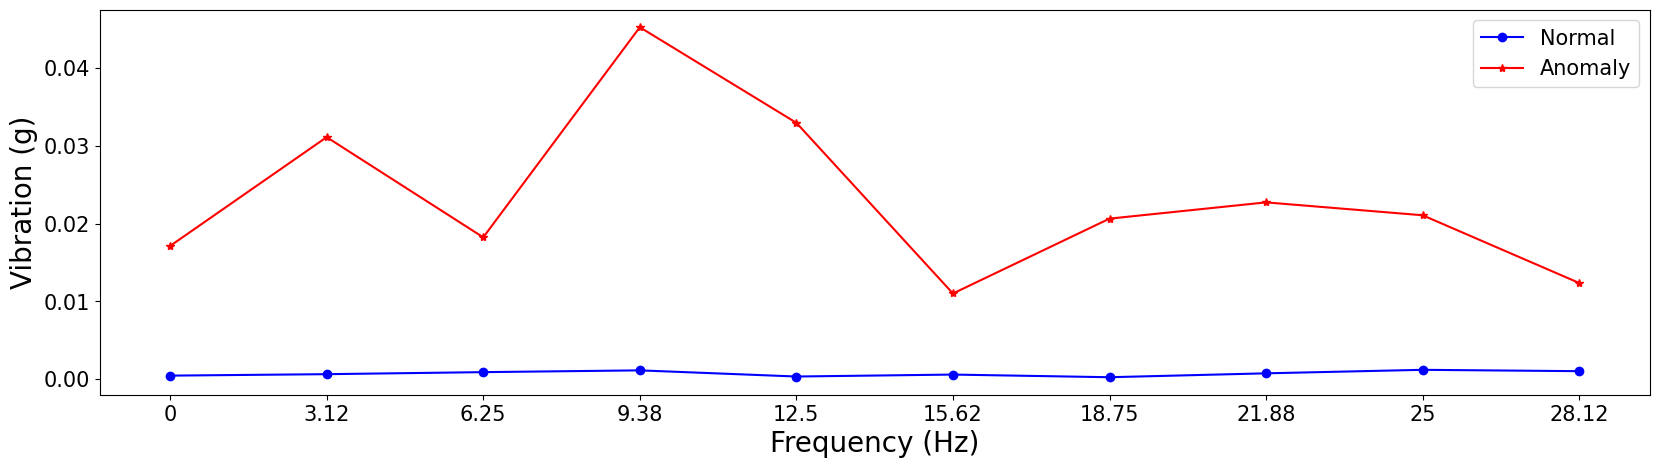

In [8]:
plt.figure(figsize=(20,5))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Vibration (g)")
plt.plot(vb_normal_df.iloc[0,1:11], marker='o', color='blue', label="Normal")
plt.plot(vb_anomaly_df.iloc[0,1:11], marker='*', color='red', label="Anomaly")
plt.legend()
plt.show()

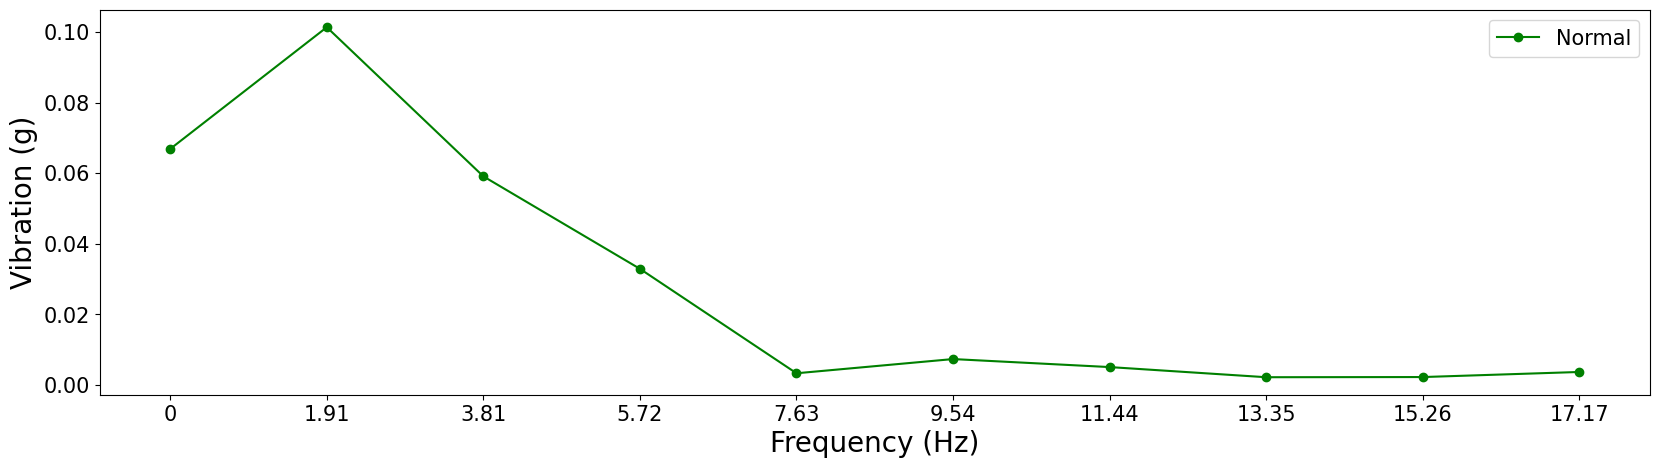

In [9]:
plt.figure(figsize=(20,5))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Vibration (g)")
plt.plot(cur_normal_df.iloc[-1, 1:11], marker='o', color='green', label="Normal")
plt.legend()
plt.show()

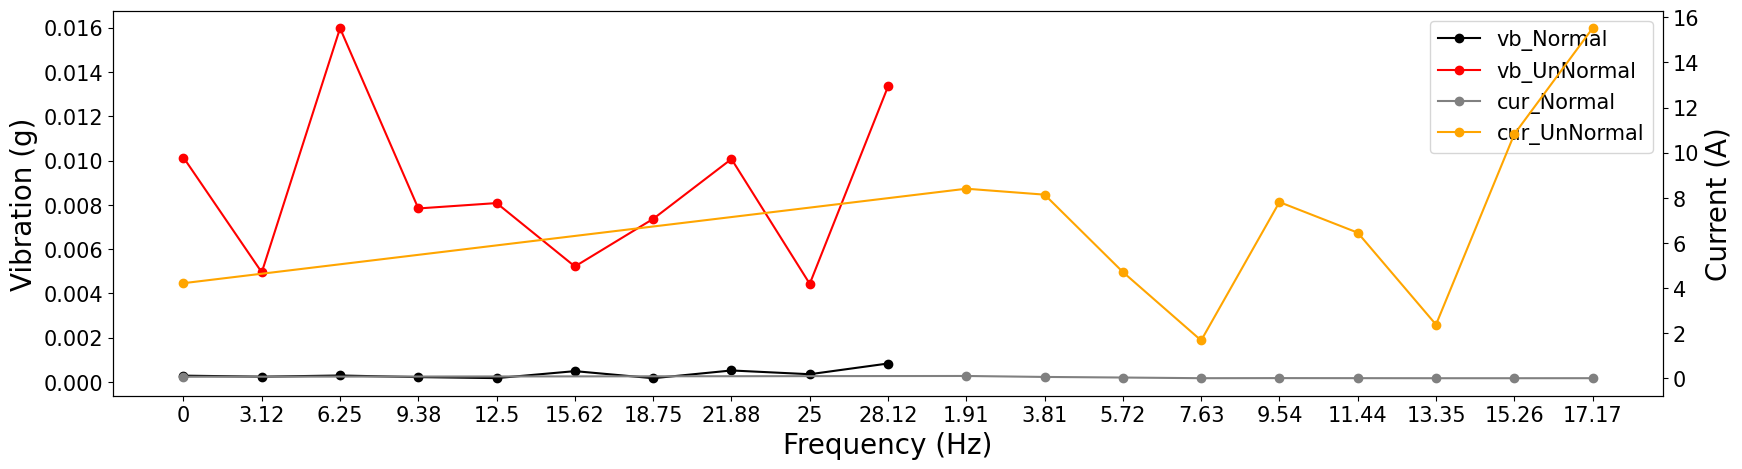

<Figure size 640x480 with 0 Axes>

In [10]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

line1 = ax1.plot(vb_normal_df.iloc[-1, 1:11], marker='o', color='black', label="vb_Normal")
line2 = ax1.plot(vb_anomaly_df.iloc[-1, 1:11], marker='o', color='red', label="vb_UnNormal")

line3 = ax2.plot(cur_normal_df.iloc[-1, 1:11], marker='o', color='gray', label="cur_Normal")
line4 = ax2.plot(cur_anomaly_df.iloc[-1, 1:11], marker='o', color='orange', label="cur_UnNormal")

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Vibration (g)")
ax2.set_ylabel("Current (A)")

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=15)

plt.show()
plt.savefig('./Chart/lat_data graph.png', dpi=fig.dpi)

#### preprocessing

In [12]:
# # split train, test data ver.1
# vb_train, vb_test = train_test_split(vb_normal_df, test_size=0.02)
# cur_train, cur_test  = train_test_split(cur_normal_df, test_size=0.02)

# display(vb_train.shape, vb_test.shape, cur_train.shape, cur_test.shape)

# vb_train = vb_train.iloc[:, 1:]
# vb_test = vb_test.iloc[:, 1:]
# cur_train = cur_train.iloc[:, 1:]
# cur_test = cur_test.iloc[:, 1:]

In [120]:
# split train, test data ver.2

vb_train=vb_normal_df.iloc[:1758,1:].values
vb_test=pd.concat([vb_normal_df.iloc[1758:,1:], vb_anomaly_df.iloc[:, 1:]], ignore_index=True).values
cur_train=cur_normal_df.iloc[:8170,1:].values
cur_test=pd.concat([cur_normal_df.iloc[8170:,1:], cur_anomaly_df.iloc[:, 1:]], ignore_index=True).values

vb_train.shape, vb_test.shape, cur_train.shape, cur_test.shape

((1758, 512), (32, 512), (8170, 1024), (64, 1024))

In [121]:
# staler
ss = StandardScaler()
vb_train_ss=ss.fit_transform(vb_train)
vb_test_ss=ss.transform(vb_test)
cur_train_ss=ss.fit_transform(cur_train)
cur_test_ss=ss.transform(cur_test)

vb_train_ss.shape, vb_test_ss.shape, cur_train_ss.shape, cur_test_ss.shape

((1758, 512), (32, 512), (8170, 1024), (64, 1024))

In [122]:
vb_train

array([[4.480800e-04, 6.338750e-04, 8.953330e-04, ..., 6.386640e-04,
        7.802130e-04, 7.276800e-04],
       [1.420000e-06, 1.761590e-04, 3.151770e-04, ..., 6.542560e-04,
        1.717880e-04, 2.378610e-04],
       [5.940610e-04, 3.785470e-04, 1.342837e-03, ..., 7.570200e-04,
        6.377550e-04, 8.721890e-04],
       ...,
       [3.470000e-05, 1.830020e-04, 2.989450e-04, ..., 9.782640e-04,
        5.645620e-04, 4.185010e-04],
       [2.421020e-04, 1.461850e-04, 5.728550e-04, ..., 8.367010e-04,
        7.735850e-04, 3.512510e-04],
       [3.488630e-04, 9.018240e-04, 7.333240e-04, ..., 1.289727e-03,
        5.461690e-04, 4.311510e-04]])

In [123]:
def func_FFT_comparition(row):
    f, ax = plt.subplots(2,2, figsize=(20,10))
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
    
    ax[0, 0].plot(vb_train_ss[row], color="blue", )
    ax[0, 0].set_title("Vibration - Normal", fontsize=15)
    
    ax[0, 1].plot(vb_test_ss[row], color="red")
    ax[0, 1].set_title("Vibration - Anormal", fontsize=15)
    
    ax[1, 0].plot(cur_train_ss[row], color="blue")
    ax[1, 0].set_title("Current - Normal", fontsize=15)
    
    ax[1, 1].plot(cur_test_ss[row], color="red")
    ax[1, 1].set_title("Current - Anomaly", fontsize=15)

    plt.suptitle(str(row) +  ' row comparition', fontsize=20)
    return plt.show()

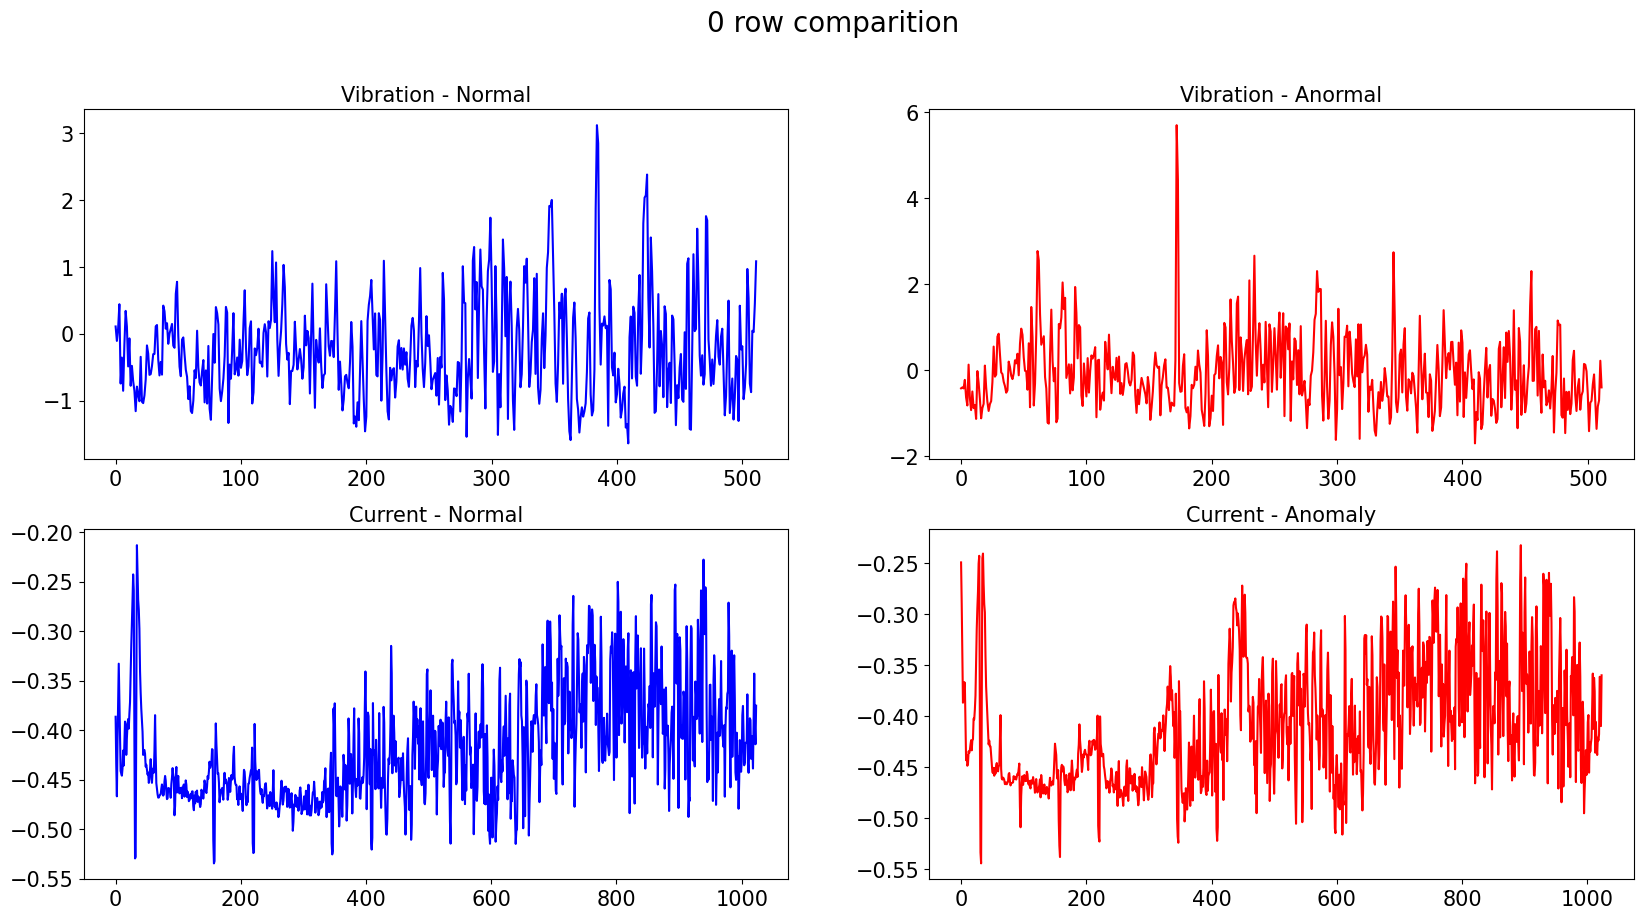

In [17]:
func_FFT_comparition(0)

#### modeling

### 합성곱 오토인코더
<img src="./Data/image/ConvAE.png" width="600px" height="550px" title="dataset shape"/>

In [124]:
# reshape : (data_size, time_step, features)
# why? conv-AE 모델은 3차원 배열형식을 입력으로 요구하므로 변경 필요
vb_train_re = vb_train_ss.reshape(vb_train_ss.shape[0], vb_train_ss.shape[1], 1)
vb_test_re = vb_test_ss.reshape(vb_test_ss.shape[0], vb_test_ss.shape[1], 1)
cur_train_re = cur_train_ss.reshape(cur_train_ss.shape[0], cur_train_ss.shape[1], 1)
cur_test_re = cur_test_ss.reshape(cur_test_ss.shape[0], cur_test_ss.shape[1], 1)

print('scale data : ',vb_train_ss.shape, vb_test_ss.shape, cur_train_ss.shape, cur_test_ss.shape)
print('reshape data : ', vb_train_re.shape, vb_test_re.shape, cur_train_re.shape, cur_test_re.shape)

scale data :  (1758, 512) (32, 512) (8170, 1024) (64, 1024)
reshape data :  (1758, 512, 1) (32, 512, 1) (8170, 1024, 1) (64, 1024, 1)


In [125]:
def ConvAE(df):
    model = Sequential()
    model.add(Input(shape=(df.shape[1], df.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=df.shape[1] // 64, padding='same', strides=2, activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=df.shape[1] // 64, padding='same', activation='relu'))
    model.add(Conv1DTranspose(filters=64, kernel_size=df.shape[1] // 64, padding='same', strides=2, activation='relu'))
    model.add(Conv1DTranspose(filters=1, kernel_size=df.shape[1] // 64, padding='same'))
    return model

In [126]:
vb_model = ConvAE(vb_train_re)
vb_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 256, 64)             │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 256, 32)             │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_4 (Conv1DTranspose) │ (None, 512, 64)             │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_5 (Conv1DTranspose) │ (None, 512, 1)              │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
cur_model = ConvAE(cur_train_re)
cur_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 512, 64)             │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 512, 32)             │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_6 (Conv1DTranspose) │ (None, 1024, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_7 (Conv1DTranspose) │ (None, 1024, 1)             │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,745 (264.63 KB)

 Trainable params: 67,745 (264.63 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# model train
vb_model.compile(loss='mae', optimizer='adam')
vb_history = vb_model.fit(x=vb_train_re, y=vb_train_re, epochs=100, validation_split=0.2, 
                          callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4471 - val_loss: 0.0833
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0589 - val_loss: 0.0524
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0440 - val_loss: 0.0339
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - val_loss: 0.0324
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0281 - val_loss: 0.0298
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0301 - val_loss: 0.0296
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0325 - val_loss: 0.0269
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - val_loss: 0.0248
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345 - val_loss: 0.0305
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - val_loss: 0.0771
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0537 - val_loss: 0.0238
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [129]:
cur_model.compile(loss='mae', optimizer='adam')
cur_history = cur_model.fit(x=cur_train_re, y=cur_train_re, epochs=100, validation_split=0.2, 
                          callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.1671 - val_loss: 0.0258
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0391 - val_loss: 0.0612
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0345 - val_loss: 0.0587
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0340 - val_loss: 0.0300
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0186 - val_loss: 0.0185
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0184 - val_loss: 0.0244
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0274 - val_loss: 0.0139
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0268 - val_loss: 0.0245
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0248 - val_loss: 0.0128
Epoch 10/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 11/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0149 - val_loss: 0.0228
Epoch 12/100
205/20

In [88]:
#check
# vb_history.history['loss']
# vb_history.history['val_loss']

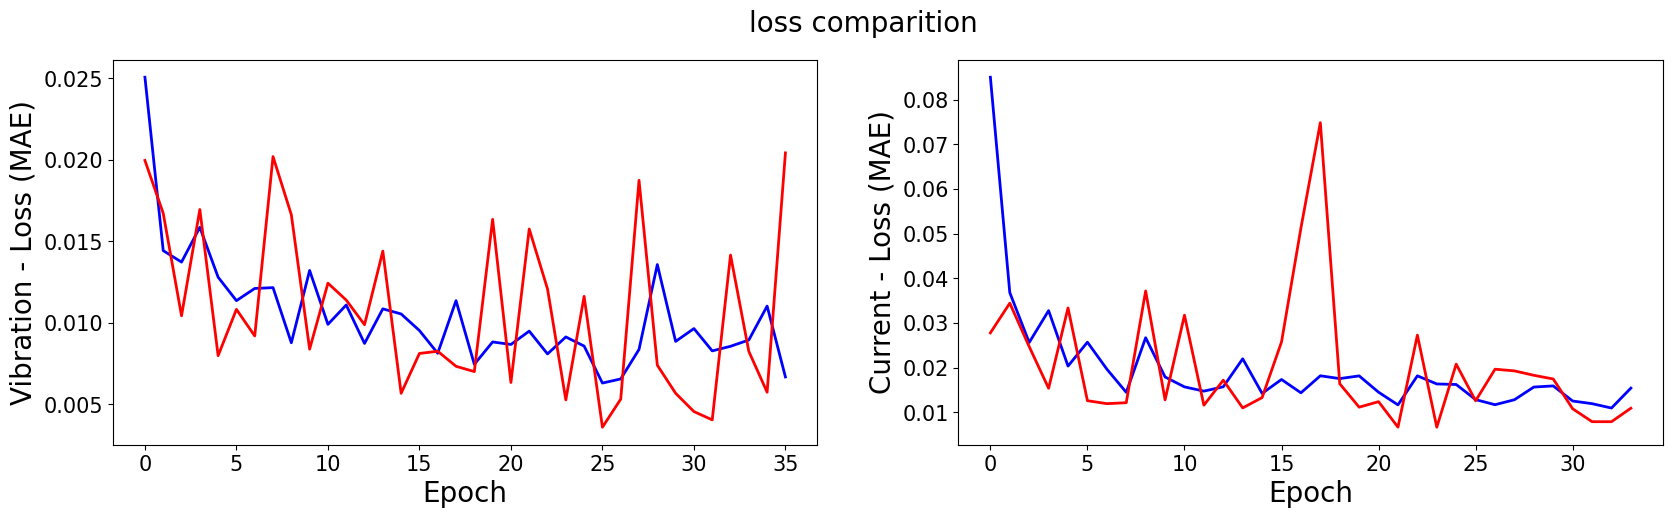

In [87]:
f, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(vb_history.history['loss'], color='blue', label='Train', linewidth=2)
ax[0].plot(vb_history.history['val_loss'], color='red', label='Validation', linewidth=2)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Vibration - Loss (MAE)")

ax[1].plot(cur_history.history['loss'], color='blue', label='Train', linewidth=2)
ax[1].plot(cur_history.history['val_loss'], color='red', label='Validation', linewidth=2)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Current - Loss (MAE)")

plt.suptitle('loss comparition', fontsize=20)
plt.show()

In [54]:
vb_yhat = vb_model.predict(vb_train_re)
cur_yhat = cur_model.predict(cur_train_re)
vb_yhat.shape, cur_yhat.shape

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


((1758, 512, 1), (8170, 1024, 1))

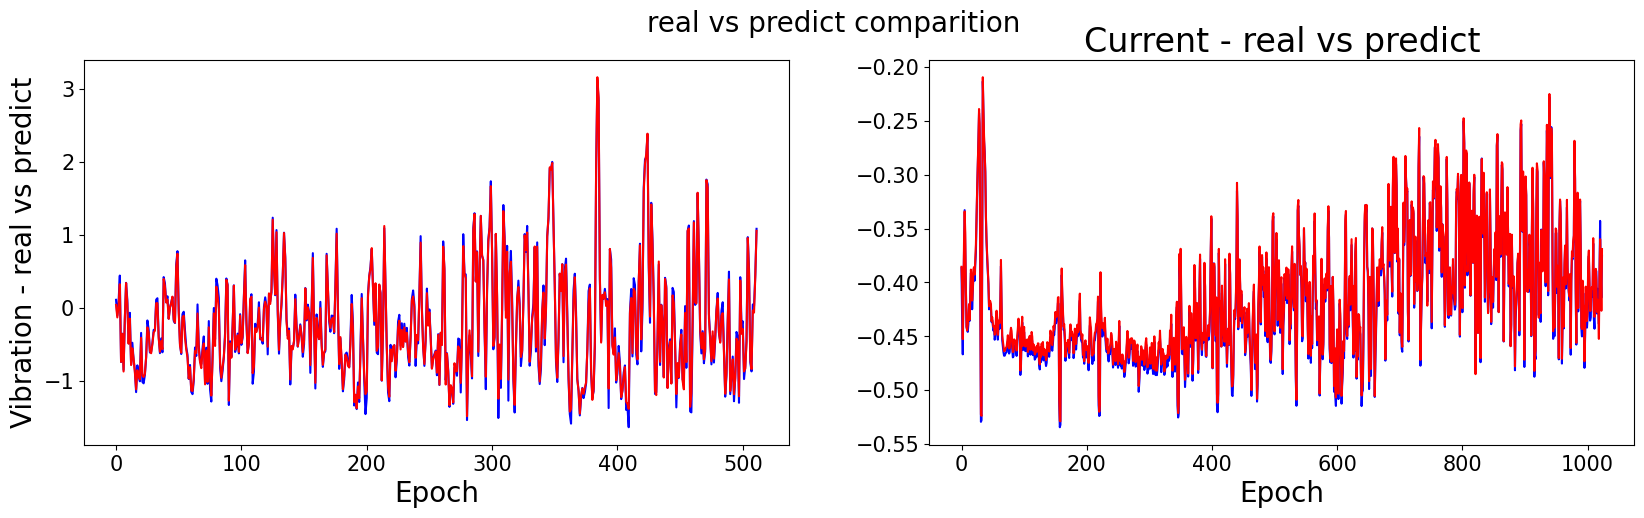

In [89]:
f, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(vb_train_re[0], color='blue', label='Target')
ax[0].plot(vb_yhat[0], color='red', label='Reconstructed')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Vibration - real vs predict")

ax[1].plot(cur_train_re[0], color='blue', label='Target')
ax[1].plot(cur_yhat[0], color='red', label='Reconstructed')
ax[1].set_xlabel("Epoch")
ax[1].set_title("Current - real vs predict")

plt.suptitle('real vs predict comparition', fontsize=20)
plt.show()

In [55]:
vb_mae = np.mean(np.abs(vb_yhat - vb_train_re), axis=1)
cur_mae = np.mean(np.abs(cur_yhat - cur_train_re), axis=1)

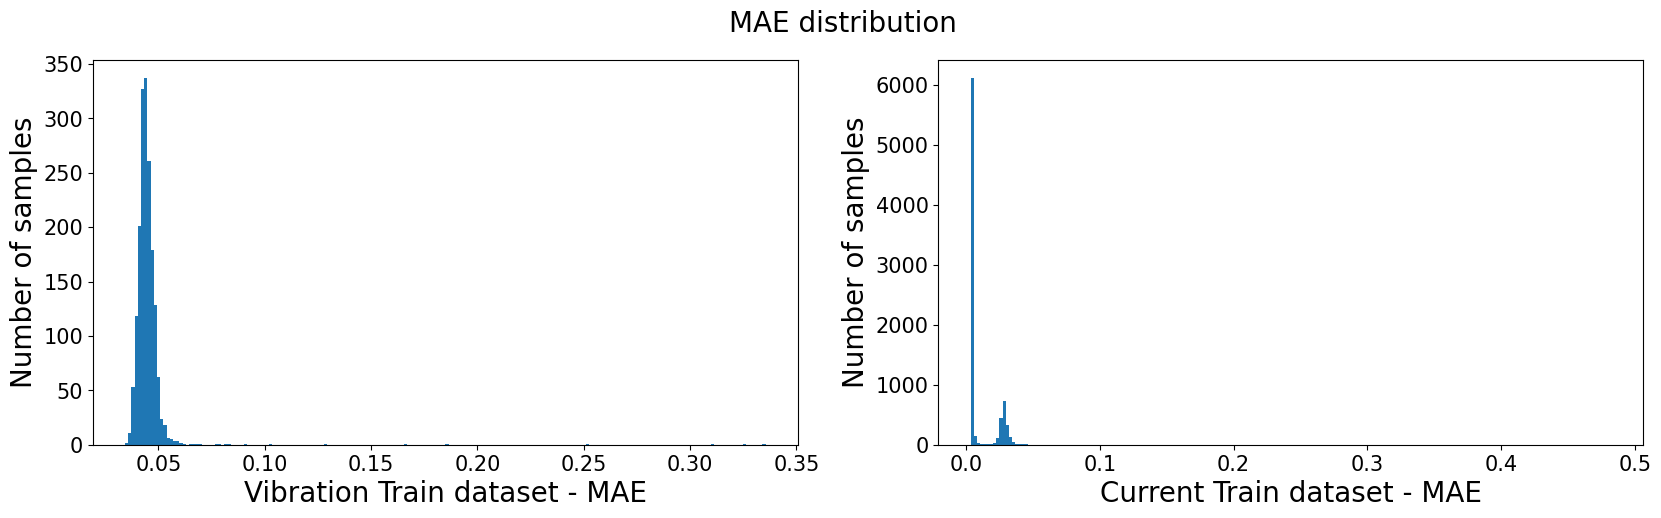

In [91]:
f, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].hist(x=vb_mae, bins=200)
ax[0].set_xlabel("Vibration Train dataset - MAE")
ax[0].set_ylabel("Number of samples")

ax[1].hist(x=cur_mae, bins=200)
ax[1].set_xlabel("Current Train dataset - MAE")
ax[1].set_ylabel("Number of samples")

plt.suptitle('MAE distribution', fontsize=20)
plt.show()

In [57]:
vb_threshold = np.mean(vb_mae) + 3 * np.std(vb_mae)
cur_threshold = np.mean(cur_mae) + 3 * np.std(cur_mae)
print('진동 데이터 임계치:', vb_threshold)
print('전류 데이터 임계치:', cur_threshold)

진동 데이터 임계치: 0.08770638902336372
전류 데이터 임계치: 0.046385864763195575


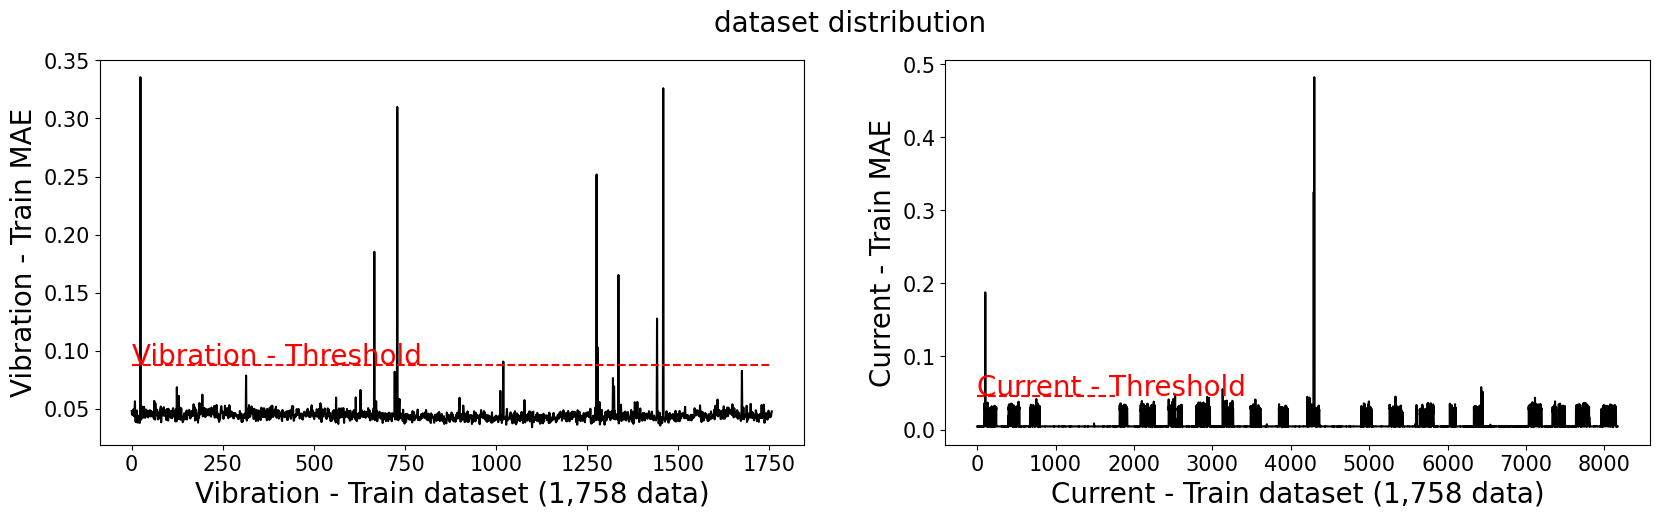

In [92]:
f, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(vb_mae, color='black')
ax[0].hlines(y=vb_threshold, xmin=0, xmax=len(vb_mae), color='red', linestyle='--')
ax[0].text(x=0, y=vb_threshold, s='Vibration - Threshold', fontsize=20, color='red')
ax[0].set_xlabel('Vibration - Train dataset (1,758 data)')
ax[0].set_ylabel('Vibration - Train MAE')

ax[1].plot(cur_mae, color='black')
ax[1].hlines(y=cur_threshold, xmin=0, xmax=len(vb_mae), color='red', linestyle='--')
ax[1].text(x=0, y=cur_threshold, s='Current - Threshold', fontsize=20, color='red')
ax[1].set_xlabel('Current - Train dataset (1,758 data)')
ax[1].set_ylabel('Current - Train MAE')

plt.suptitle('dataset distribution', fontsize=20)
plt.show()

In [94]:
vb_yhat_test = vb_model.predict(vb_test_re)
vb_mae_test = np.mean(np.abs(vb_yhat_test - vb_test_re), axis=1)

cur_yhat_test = cur_model.predict(cur_test_re)
cur_mae_test = np.mean(np.abs(cur_yhat_test - cur_test_re), axis=1)
vb_mae_test.shape, cur_mae_test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


((32, 1), (64, 1))

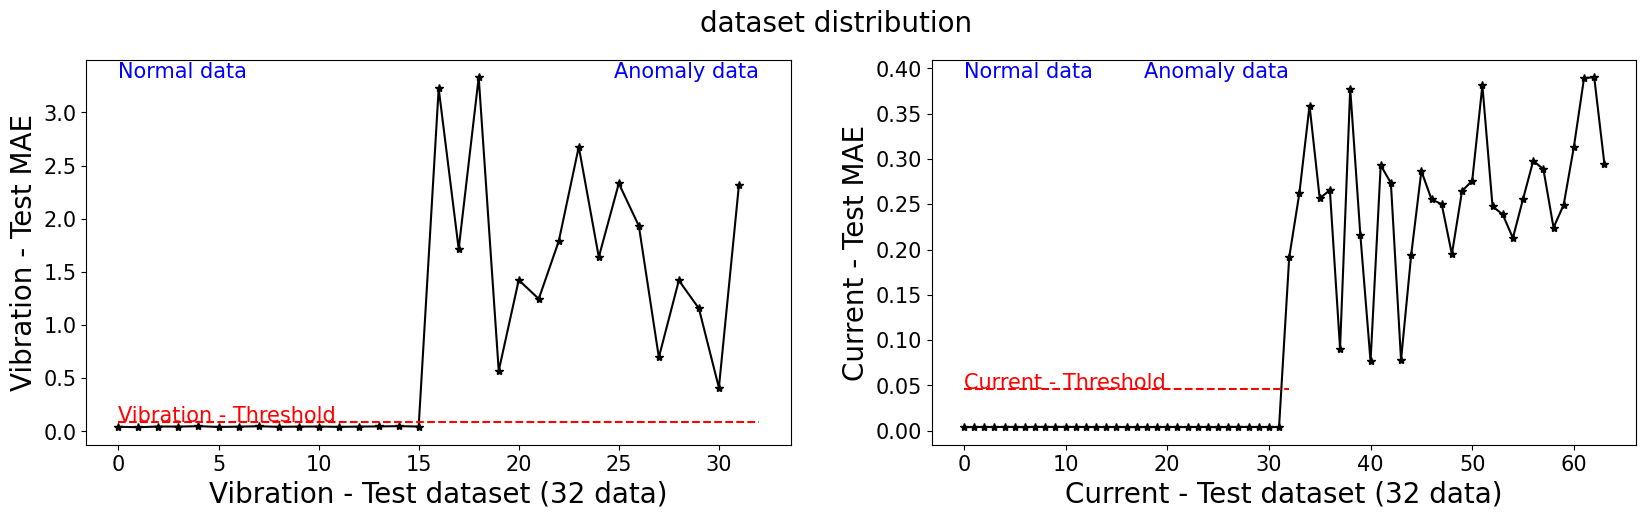

In [103]:
f, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(vb_mae_test, color='black', marker='*')  # 분포
# ax[0].plt.vlines(x=15.5, ymin=0, ymax=max(vb_mae_test), color='blue', linestyle='--')
ax[0].text(x=0, y=max(vb_mae_test), s='Normal data', horizontalalignment='left', color='blue', fontsize=15)
ax[0].text(x=32, y=max(vb_mae_test), s='Anomaly data', horizontalalignment='right', color='blue', fontsize=15)
ax[0].text(x=0, y=vb_threshold, s='Vibration - Threshold', fontsize=15, color='red')  # 임계치
ax[0].hlines(y=vb_threshold, xmin=0, xmax=len(vb_mae_test), color='red', linestyle='--')
ax[0].set_xlabel('Vibration - Test dataset (32 data)')
ax[0].set_ylabel('Vibration - Test MAE')

ax[1].plot(cur_mae_test, color='black', marker='*')  # 분포
# ax[0].plt.vlines(x=15.5, ymin=0, ymax=max(vb_mae_test), color='blue', linestyle='--')
ax[1].text(x=0, y=max(cur_mae_test), s='Normal data', horizontalalignment='left', color='blue', fontsize=15)
ax[1].text(x=32, y=max(cur_mae_test), s='Anomaly data', horizontalalignment='right', color='blue', fontsize=15)
ax[1].text(x=0, y=cur_threshold, s='Current - Threshold', fontsize=15, color='red')  # 임계치
ax[1].hlines(y=cur_threshold, xmin=0, xmax=len(vb_mae_test), color='red', linestyle='--')
ax[1].set_xlabel('Current - Test dataset (32 data)')
ax[1].set_ylabel('Current - Test MAE')

plt.suptitle('dataset distribution', fontsize=20)
plt.show()